*First compiled on: December 3, 2016.*

# Simulating myeloid progenitors

In [1]:
import numpy as np
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()

scanpy==1.0 anndata==0.5.8 numpy==1.14.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


Here, we simulate data using a literature-curated boolean gene
regulatory network, which is believed to describe myeloid differentiation
([Krumsiek *et al.*, 2011](https://doi.org/10.1371/journal.pone.0022649)). Using [sim](https://github.com/theislab/scanpy/tree/master/scanpy/tools/sim.py), the
[boolean model](https://github.com/theislab/scanpy/tree/master/scanpy/sim_models/krumsiek11.txt)
```
Gata2 = Gata2 and not (Gata1 and Fog1) and not Pu.1
Gata1 = (Gata1 or Gata2 or Fli1) and not Pu.1
Fog1 = Gata1
EKLF = Gata1 and not Fli1
Fli1 = Gata1 and not EKLF
SCL = Gata1 and not Pu.1
Cebpa = Cebpa and not (Gata1 and Fog1 and SCL)
Pu.1 = (Cebpa or Pu.1) and not (Gata1 or Gata2)
cJun = Pu.1 and not Gfi1
EgrNab = (Pu.1 and cJun) and not Gfi1
Gfi1 = Cebpa and not EgrNab
```
is translated into a stochastic differential equation ([Wittmann *et al.*, 2009](#ref_wittmann09)). Simulations result
in branching time series of gene expression, where each branch corresponds to a
certain cell fate of common myeloid progenitors (megakaryocytes, erythrocytes,
granulocytes and monocytes).

Instead of simulating the data as in the next line, you can also retrieve it from the builtin examples
```
adata = sc.datasets.krumsiek11()
```

This uses the default parameters from [here](https://github.com/theislab/scanpy/tree/master/scanpy/sim_models/krumsiek11_params.txt). To change parameters, read in a different parameter file or simply pass them to `sc.tl.sim`.

In [2]:
adata = sc.tl.sim('krumsiek11')

reading params file /Users/alexwolf/_hholtz/01_projects/1512_scanpy/scanpy/scanpy/sim_models/krumsiek11_params.txt
reading simulation results ./write/krumsiek11_sim/sim_000017.txt
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Plot the four realizations of time series.

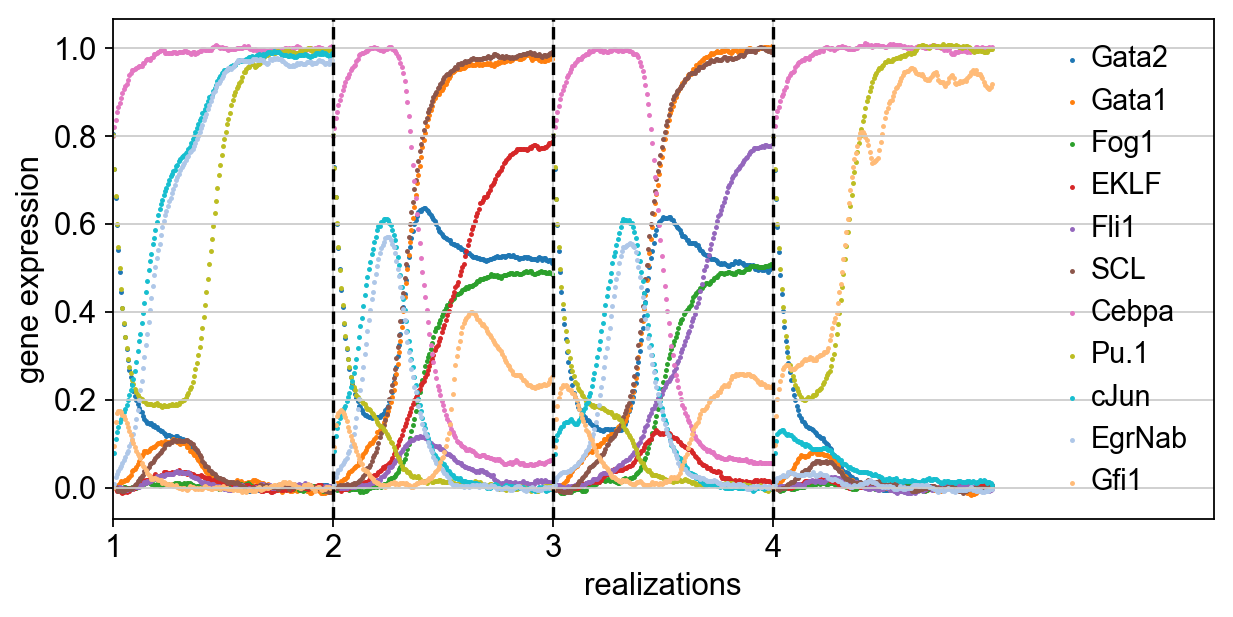

In [3]:
sc.pl.sim(adata)

Compute further visualizations.

In [4]:
sc.tl.tsne(adata)

computing tSNE
    using data matrix X directly
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:04.236) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing neighbors
    using data matrix X directly
    finished (0:00:02.652) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fr"
    finished (0:00:02.969) --> added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obs)


In [7]:
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.draw_graph(adata)

computing neighbors
    initialized `.distances` `.connectivities` 
    using data matrix X directly
    finished (0:00:00.303) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fr"
    finished (0:00:03.286) --> added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obs)


Inspecting the genes of the fixed poitns, we can make the following annotation.

In [8]:
fate_labels = {0: 'progenitor', 159: 'monocyte', 319: 'erythrocyte', 
               459: 'megacaryocyte', 619: 'neutrophil'}
adata.uns['highlights'] = fate_labels
cell_type = np.array(['progenitor' for i in range(adata.n_obs)])                                                                                                               
cell_type[80:160] = 'monocyte'                                                                                                                                                  
cell_type[240:320] = 'erythrocyte'                                                                                                                                              
cell_type[400:480] = 'megakaryocyte'                                                                                                                                            
cell_type[560:640] = 'neutrophil'
adata.obs['cell_type'] = cell_type

... storing 'cell_type' as categorical type
    access categories as adata.obs['cell_type'].cat.categories


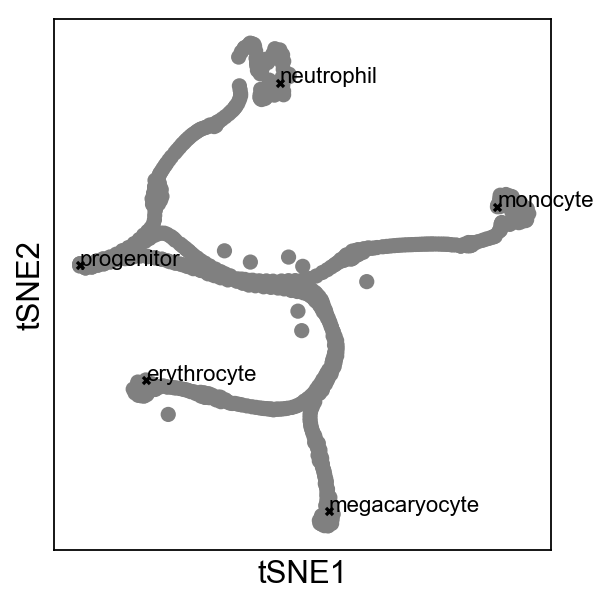

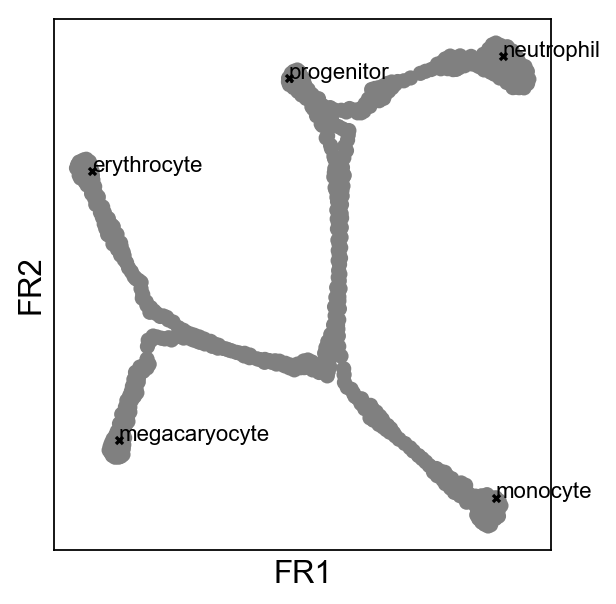

In [9]:
sc.pl.tsne(adata)
sc.pl.draw_graph(adata)

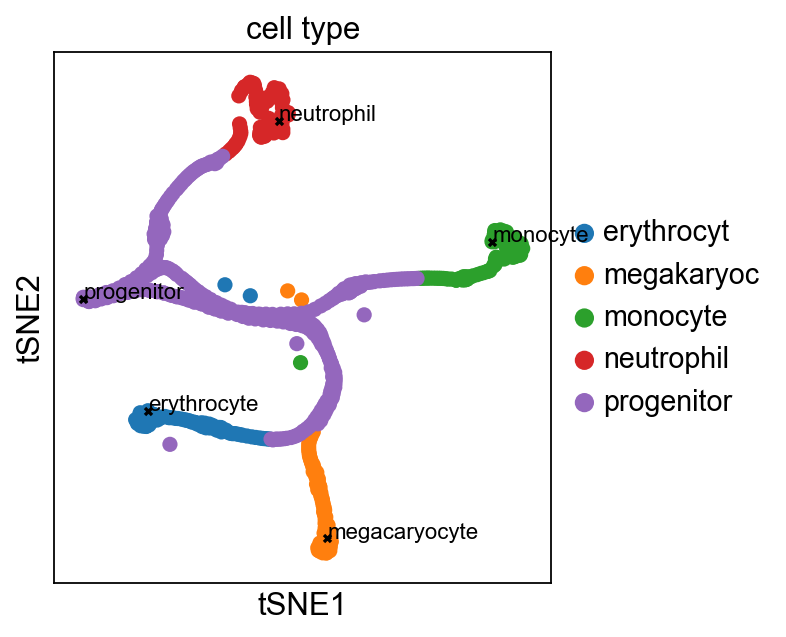

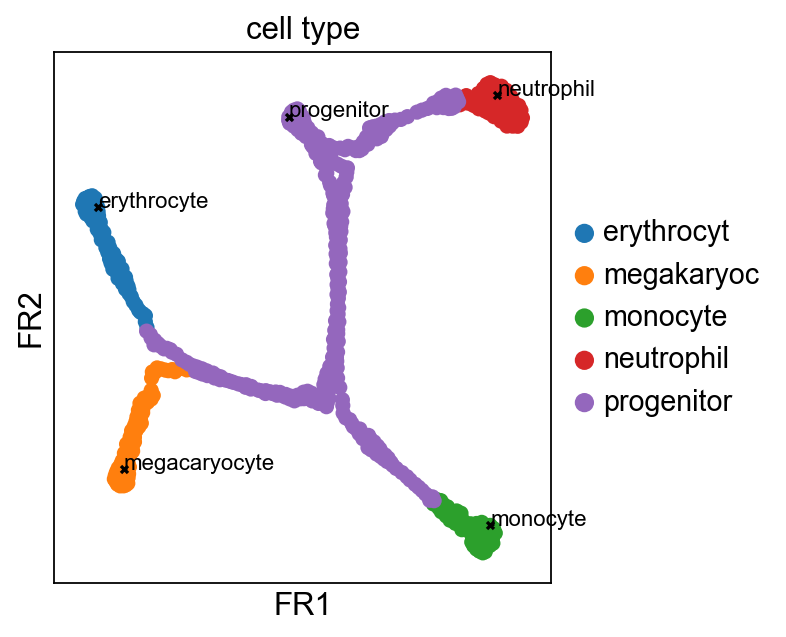

In [10]:
sc.pl.tsne(adata, color='cell_type')
sc.pl.draw_graph(adata, color='cell_type')

### Reconstructing progression and branching using DPT

In [13]:
adata.uns['iroot'] = 0
sc.tl.dpt(adata, n_branchings=2)

performing Diffusion Pseudotime analysis
    initialized `.distances` `.connectivities` 
    eigenvalues of transition matrix
    [ 1.            0.9994561076  0.9990158081  0.9974680543  0.9971337318
      0.9936081171  0.9897011518  0.983776629   0.9828016162  0.9784392118]
    this uses a hierarchical implementation
    finished (0:00:00.333) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


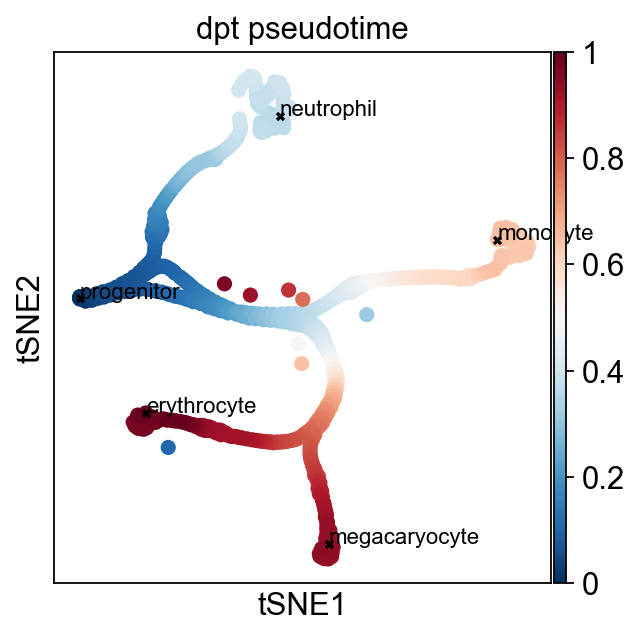

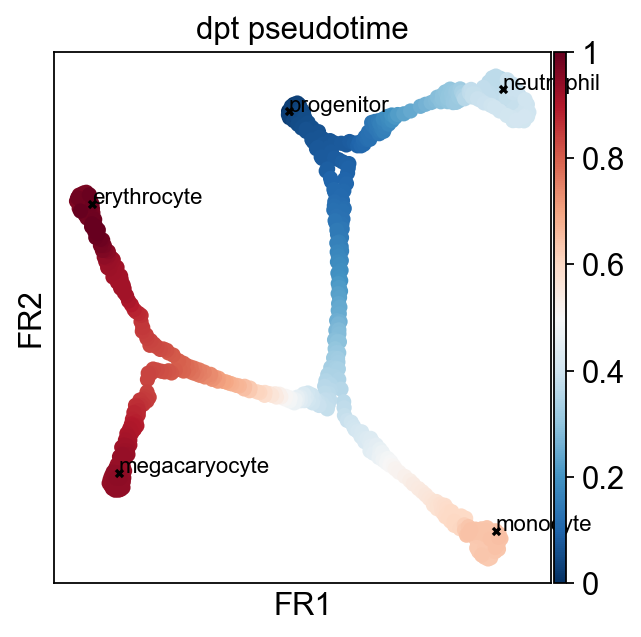

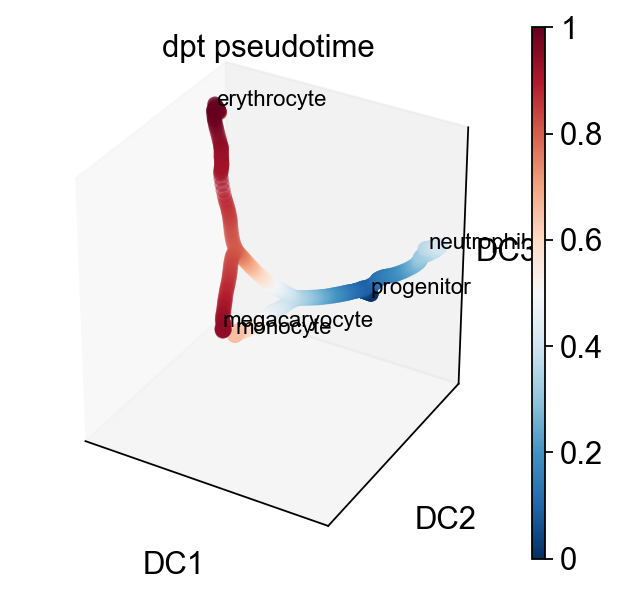

In [14]:
sc.pl.tsne(adata, color='dpt_pseudotime')
sc.pl.draw_graph(adata, color='dpt_pseudotime')
sc.pl.diffmap(adata, color='dpt_pseudotime', projection='3d')

The "cuts" into branches are quite arbitrary. Use PAGA instead.

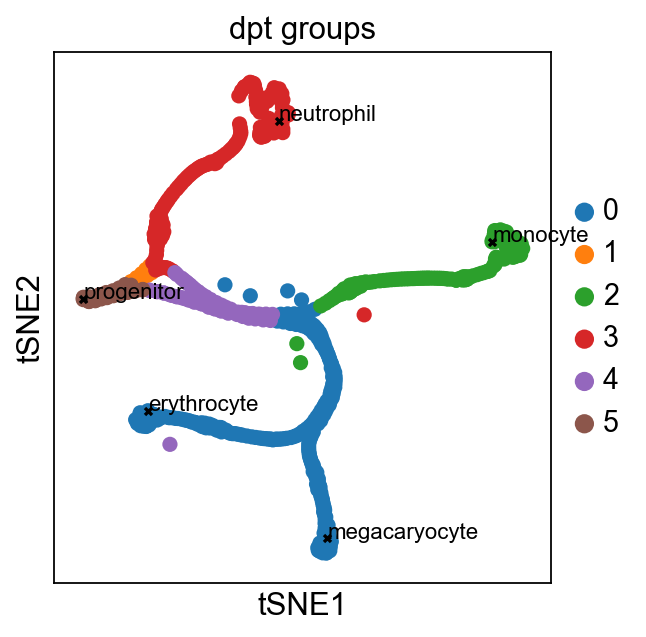

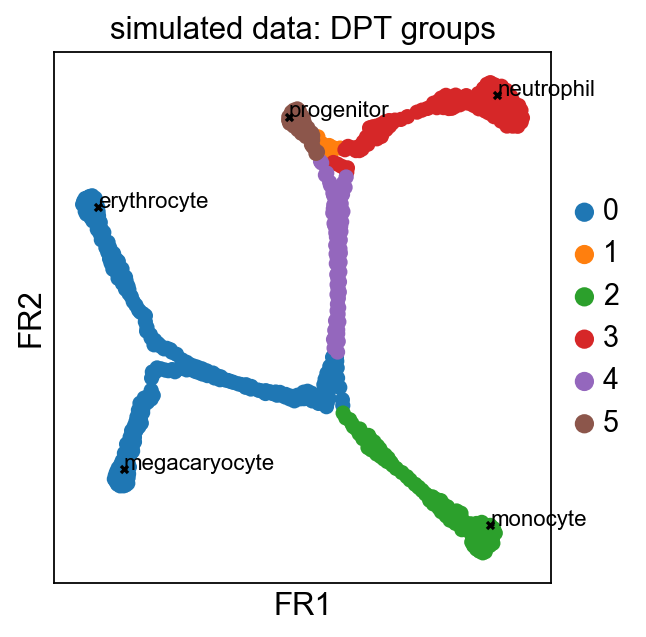

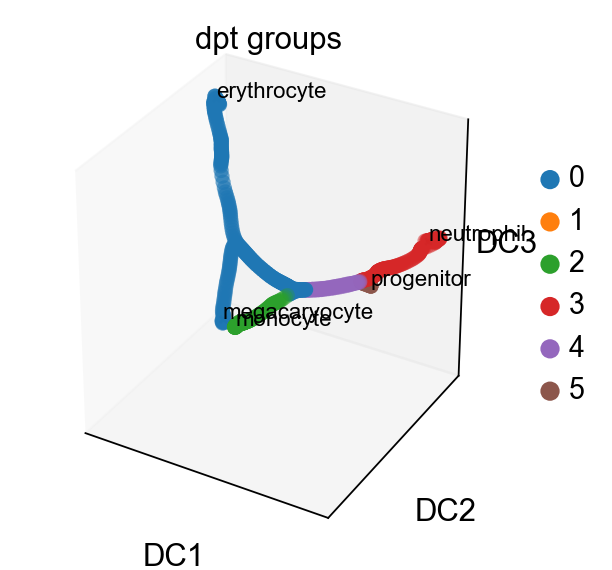

In [15]:
sc.pl.tsne(adata, color='dpt_groups')
sc.pl.draw_graph(adata, color='dpt_groups', title='simulated data: DPT groups')
sc.pl.diffmap(adata, color='dpt_groups', projection='3d')